In [7]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym

# hyperparameters
H = 200  # number of hidden layer neurons
batch_size = 10  # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99  # discount factor for reward
decay_rate = 0.99  # decay factor for RMSProp leaky sum of grad^2
resume = False  # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80  # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H, D) / np.sqrt(D)  # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

# update buffers that add up gradients over a batch
grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}
rmsprop_cache = {k: np.zeros_like(v)
                 for k, v in model.items()}  # rmsprop memory


def sigmoid(x):
    # sigmoid "squashing" function to interval [0,1]
    return 1.0 / (1.0 + np.exp(-x))


def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0:
            # reset the sum, since this was a game boundary (pong specific!)
            running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h < 0] = 0  # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h  # return probability of taking action 2, and hidden state


def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0  # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1': dW1, 'W2': dW2}


env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None  # used in computing the difference frame
xs, hs, dlogps, drs = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render:
        env.render()

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3  # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x)  # observation
    hs.append(h)  # hidden state
    y = 1 if action == 2 else 0  # a "fake label"
    # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
    dlogps.append(y - aprob)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    # record reward (has to be done after we call step() to get reward for previous action)
    drs.append(reward)

    if done:  # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs, hs, dlogps, drs = [], [], [], []  # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        # modulate the gradient with advantage (PG magic happens right here.)
        epdlogp *= discounted_epr
        grad = policy_backward(eph, epdlogp)
        for k in model:
            grad_buffer[k] += grad[k]  # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k, v in model.items():
                g = grad_buffer[k]  # gradient
                rmsprop_cache[k] = decay_rate * \
                    rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / \
                    (np.sqrt(rmsprop_cache[k]) + 1e-5)
                # reset batch gradient buffer
                grad_buffer[k] = np.zeros_like(v)

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * \
            0.99 + reward_sum * 0.01
        print(('resetting env. episode reward total was %f. running mean: %f' %
              (reward_sum, running_reward)))
        if episode_number % 100 == 0:
            pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset()  # reset env
        prev_x = None

    if reward != 0:  # Pong has either +1 or -1 reward exactly when game ends.
        print(('ep %d: game finished, reward: %f' %
              (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))

ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -21.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, rewar

KeyboardInterrupt: 

In [8]:
import numpy as np
import pickle
import gym

In [9]:
# hyperparameters
H = 200  # number of hidden layer neurons
batch_size = 10  # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99  # discount factor for reward
decay_rate = 0.99  # decay factor for RMSProp leaky sum of grad^2
resume = False  # resume from previous checkpoint?
render = False

In [10]:
# model initialization
D = 80 * 80  # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H, D) / np.sqrt(D)  # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

# update buffers that add up gradients over a batch
grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}
rmsprop_cache = {k: np.zeros_like(v)
                 for k, v in model.items()}  # rmsprop memory

In [11]:
def sigmoid(x):
    # sigmoid "squashing" function to interval [0,1]
    return 1.0 / (1.0 + np.exp(-x))

In [12]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

In [13]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0:
            # reset the sum, since this was a game boundary (pong specific!)
            running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [14]:
def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h < 0] = 0  # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h  # return probability of taking action 2, and hidden state

In [15]:
def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0  # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1': dW1, 'W2': dW2}

In [16]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None  # used in computing the difference frame
xs, hs, dlogps, drs = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 0

In [17]:
render

False

In [19]:
observation.shape

(210, 160, 3)

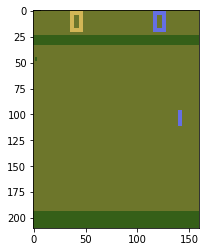

In [22]:
import matplotlib.pyplot as plt
plt.imshow(observation)
plt.show()

In [23]:
cur_x.shape

(6400,)

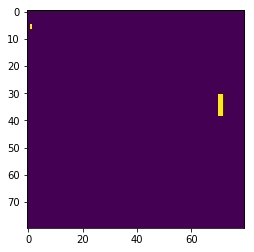

In [28]:
def prepro_(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return I
see_img = prepro_(observation).reshape(80, 80)
plt.imshow(see_img)
plt.show()

In [29]:
while True:
    if render:
        env.render()

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3  # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x)  # observation
    hs.append(h)  # hidden state
    y = 1 if action == 2 else 0  # a "fake label"
    # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
    dlogps.append(y - aprob)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    # record reward (has to be done after we call step() to get reward for previous action)
    drs.append(reward)

    if done:  # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs, hs, dlogps, drs = [], [], [], []  # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        # modulate the gradient with advantage (PG magic happens right here.)
        epdlogp *= discounted_epr
        grad = policy_backward(eph, epdlogp)
        for k in model:
            grad_buffer[k] += grad[k]  # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k, v in model.items():
                g = grad_buffer[k]  # gradient
                rmsprop_cache[k] = decay_rate * \
                    rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / \
                    (np.sqrt(rmsprop_cache[k]) + 1e-5)
                # reset batch gradient buffer
                grad_buffer[k] = np.zeros_like(v)

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * \
            0.99 + reward_sum * 0.01
        print(('resetting env. episode reward total was %f. running mean: %f' %
              (reward_sum, running_reward)))
        if episode_number % 100 == 0:
            pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset()  # reset env
        prev_x = None

    if reward != 0:  # Pong has either +1 or -1 reward exactly when game ends.
        print(('ep %d: game finished, reward: %f' %
              (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))

ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: 1.000000 !!!!!!!!
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, reward: -1.000000
ep 1: game finishe

ep 8: game finished, reward: -1.000000
ep 8: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.019604
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: 1.000000 !!!!!!!!
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finishe

ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.057121
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 

ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: 1.000000 !!!!!!!!
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.070922
ep 27: game finished, reward: -1.000000
ep 27: game finished, reward: -1.000000
ep 27: game finished, reward: -1.000000
ep 27: game finished, reward: -1.000000
ep 27: game finished, reward: -1.000000
ep 27: game finished, reward: -1.00

ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: 1.000000 !!!!!!!!
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
ep 35: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.112356
ep 36: game finished, reward: -1.000000
ep 36: game finished, reward: -1.00

ep 43: game finished, reward: -1.000000
ep 43: game finished, reward: -1.000000
ep 43: game finished, reward: -1.000000
ep 43: game finished, reward: 1.000000 !!!!!!!!
ep 43: game finished, reward: -1.000000
ep 43: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.123276
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.000000
ep 44: game finished, reward: -1.00

ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
ep 52: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.121468
ep 53: game finished, reward: -1.000000
ep 53: game finished, reward: -1.000000
ep 53: game finished, reward: -1.000000
ep 53: game finished, reward: -1.000000
ep 53: game finished, reward: -1.000000
ep 53: game finished, reward: -1.000000
ep 

ep 60: game finished, reward: 1.000000 !!!!!!!!
ep 60: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.130712
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.000000
ep 61: game finished, reward: -1.00

ep 69: game finished, reward: -1.000000
ep 69: game finished, reward: -1.000000
ep 69: game finished, reward: -1.000000
ep 69: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.195991
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 70: game finished, reward: -1.000000
ep 

ep 78: game finished, reward: -1.000000
ep 78: game finished, reward: -1.000000
ep 78: game finished, reward: -1.000000
ep 78: game finished, reward: -1.000000
ep 78: game finished, reward: -1.000000
ep 78: game finished, reward: -1.000000
ep 78: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.245921
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 79: game finished, reward: -1.000000
ep 

ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: 1.000000 !!!!!!!!
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
ep 87: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.252708
ep 88: game finished, reward: -1.000000
ep 88: game finished, reward: -1.000000
ep 88: game finished, reward: -1.000000
ep 88: game finished, reward: -1.000000
ep 88: game finished, reward: -1.000000
ep 88: game finished, reward: -1.000000
ep 88: game finished, reward: -1.000000
ep 88: game finished, reward: -1.00

ep 95: game finished, reward: -1.000000
ep 95: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.242214
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 96: game finished, reward: -1.000000
ep 

ep 104: game finished, reward: 1.000000 !!!!!!!!
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
ep 104: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.259018
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game finished, reward: -1.000000
ep 105: game 

ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
ep 113: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.294746
ep 114: game finished, reward: -1.000000
ep 114: game finished, reward: -1.000000
ep 114: game finished

ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: 1.000000 !!!!!!!!
ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: -1.000000
ep 121: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -20.280899
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game finished, reward: -1.000000
ep 122: game 

ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
ep 130: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.314552
ep 131: game finished, reward: -1.000000
ep 131: game finished, reward: -1.000000
ep 131: game finished

ep 138: game finished, reward: -1.000000
ep 138: game finished, reward: -1.000000
ep 138: game finished, reward: -1.000000
ep 138: game finished, reward: -1.000000
ep 138: game finished, reward: -1.000000
ep 138: game finished, reward: -1.000000
ep 138: game finished, reward: -1.000000
ep 138: game finished, reward: -1.000000
ep 138: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.319264
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished, reward: -1.000000
ep 139: game finished

ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: 1.000000 !!!!!!!!
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: 1.000000 !!!!!!!!
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
ep 147: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.311247
ep 14

ep 155: game finished, reward: 1.000000 !!!!!!!!
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
ep 155: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.297101
ep 156: game finished, reward: -1.000000
ep 156: game finished, reward: -1.000000
ep 156: game finished, reward: -1.000000
ep 156: game finished, reward: -1.000000
ep 156: game finished, reward: -1.000000
ep 156: game finished, reward: -1.000000
ep 156: game finished, reward: 1.000000 !!!!!!!!
ep 156: game finished, reward: -1.000000
ep 156: game finished, reward: -1.000000
ep 15

ep 163: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.312676
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
ep 164: game finished, reward: -1.000000
resetting env. episod

ep 172: game finished, reward: -1.000000
ep 172: game finished, reward: -1.000000
ep 172: game finished, reward: -1.000000
ep 172: game finished, reward: -1.000000
ep 172: game finished, reward: -1.000000
ep 172: game finished, reward: -1.000000
ep 172: game finished, reward: -1.000000
ep 172: game finished, reward: -1.000000
ep 172: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.352417
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished, reward: -1.000000
ep 173: game finished

ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: 1.000000 !!!!!!!!
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
ep 181: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.378721
ep 182: game finished, reward: -1.000000
ep 182: game finished, reward: -1.000000
ep 182: game finished, reward: -1.000000
ep 182: game finished, reward: -1.000000
ep 182: game 

ep 189: game finished, reward: -1.000000
ep 189: game finished, reward: -1.000000
ep 189: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.407312
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished, reward: -1.000000
ep 190: game finished

ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
ep 198: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.420429
ep 199: game finished, reward: -1.000000
ep 199: game finished, reward: -1.000000
ep 199: game finished, reward: -1.000000
ep 199: game finished, reward: -1.000000
ep 199: game finished, reward: 1.000000 !!!!!!!!
ep 199: game finished, reward: -1.000000
ep 199: game finished, reward: 1.000000 !!!!!!!!
ep 199: game finished, reward: -1.000000
ep 199: game finished, reward: -1.000000
ep 19

ep 206: game finished, reward: -1.000000
ep 206: game finished, reward: -1.000000
ep 206: game finished, reward: -1.000000
ep 206: game finished, reward: -1.000000
ep 206: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.389010
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished, reward: -1.000000
ep 207: game finished

ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: 1.000000 !!!!!!!!
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: 1.000000 !!!!!!!!
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
ep 215: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.373909
ep 216: game finished, reward: -1.000000
ep 216: game finished, reward: -1.000000
ep 216: game finished, reward: -1.000000
ep 21

ep 223: game finished, reward: -1.000000
ep 223: game finished, reward: -1.000000
ep 223: game finished, reward: -1.000000
ep 223: game finished, reward: -1.000000
ep 223: game finished, reward: -1.000000
ep 223: game finished, reward: -1.000000
ep 223: game finished, reward: -1.000000
ep 223: game finished, reward: 1.000000 !!!!!!!!
ep 223: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.364238
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game finished, reward: -1.000000
ep 224: game 

ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: 1.000000 !!!!!!!!
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
ep 232: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.380975
ep 233: game finished, reward: -1.000000
ep 233: game finished, reward: -1.000000
ep 233: game finished, reward: -1.000000
ep 233: game 

ep 240: game finished, reward: -1.000000
ep 240: game finished, reward: -1.000000
ep 240: game finished, reward: -1.000000
ep 240: game finished, reward: -1.000000
ep 240: game finished, reward: -1.000000
ep 240: game finished, reward: -1.000000
ep 240: game finished, reward: -1.000000
ep 240: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.380076
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: 1.000000 !!!!!!!!
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game finished, reward: -1.000000
ep 241: game 

ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: 1.000000 !!!!!!!!
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
ep 249: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.375934
ep 250: game finished, reward: -1.000000
ep 250: game 

ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
ep 257: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.366304
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished, reward: -1.000000
ep 258: game finished

ep 265: game finished, reward: -1.000000
ep 265: game finished, reward: -1.000000
ep 265: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -20.337798
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished, reward: -1.000000
ep 266: game finished

ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
ep 274: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.356920
ep 275: game finished, reward: -1.000000
ep 275: game finished, reward: -1.000000
ep 275: game finished, reward: -1.000000
ep 275: game finished, reward: -1.000000
ep 275: game finished, reward: -1.000000
ep 275: game finished, reward: -1.000000
ep 275: game finished, reward: -1.000000
ep 275: game finished, reward: -1.000000
ep 275: game finished, reward: -1.000000
ep 275: game finished

ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
ep 283: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.384572
ep 284: game finished, reward: -1.000000
ep 284: game finished, reward: -1.000000
ep 284: game finished

ep 291: game finished, reward: -1.000000
ep 291: game finished, reward: -1.000000
ep 291: game finished, reward: -1.000000
ep 291: game finished, reward: -1.000000
ep 291: game finished, reward: -1.000000
ep 291: game finished, reward: -1.000000
ep 291: game finished, reward: -1.000000
ep 291: game finished, reward: -1.000000
ep 291: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.384175
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished, reward: -1.000000
ep 292: game finished

ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.390254
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished

ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
ep 308: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.359137
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: 1.000000 !!!!!!!!
ep 309: game 

ep 316: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.361176
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: 1.000000 !!!!!!!!
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game 

ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.358481
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished

ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.349711
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished

ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: 1.000000 !!!!!!!!
ep 342: game finished, reward: 1.000000 !!!!!!!!
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: 1.000000 !!!!!!!!
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: 1.000000 !!!!!!!!
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
resetting env. episode reward total was -17.000000. running mean: 

ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.344247
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished, reward: -1.000000
ep 351: game finished

ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
ep 359: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.352531
ep 360: game finished, reward: -1.000000
ep 360: game finished, reward: -1.000000
ep 360: game finished, reward: -1.000000
ep 360: game finished

ep 367: game finished, reward: 1.000000 !!!!!!!!
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
ep 367: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.315403
ep 368: game finished, reward: -1.000000
ep 368: game finished, reward: 1.000000 !!!!!!!!
ep 368: game finished, reward: -1.000000
ep 368: game finished, reward: -1.000000
ep 368: game finished, reward: -1.000000
ep 368: game finished, reward: -1.000000
ep 368: game finished, reward: -1.000000
ep 368: game finished, reward: -1.000000
ep 368: game finished, reward: -1.000000
ep 368: game finished, reward: -1.000000
ep 36

ep 375: game finished, reward: -1.000000
ep 375: game finished, reward: -1.000000
ep 375: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.300841
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished, reward: -1.000000
ep 376: game finished

ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
ep 384: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.293454
ep 385: game finished, reward: -1.000000
ep 385: game finished, reward: -1.000000
ep 385: game finished, reward: -1.000000
ep 385: game finished, reward: -1.000000
ep 385: game finished, reward: 1.000000 !!!!!!!!
ep 385: game 

ep 392: game finished, reward: -1.000000
ep 392: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.328717
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: -1.000000
ep 393: game finished, reward: 1.000000 !!!!!!!!
ep 393: game 

ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
ep 401: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.329417
ep 402: game finished, reward: -1.000000
ep 402: game finished, reward: -1.000000
ep 402: game finished, reward: -1.000000
ep 402: game finished, reward: -1.000000
ep 402: game finished, reward: -1.000000
ep 402: game finished, reward: -1.000000
ep 402: game finished, reward: -1.000000
ep 402: game finished

ep 409: game finished, reward: -1.000000
ep 409: game finished, reward: -1.000000
ep 409: game finished, reward: -1.000000
ep 409: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.333861
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished, reward: -1.000000
ep 410: game finished

ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: 1.000000 !!!!!!!!
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
ep 418: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.323430
ep 419: game finished, reward: -1.000000
ep 419: game finished, reward: -1.000000
ep 419: game finished, reward: -1.000000
ep 419: game finished, reward: -1.000000
ep 419: game 

ep 426: game finished, reward: -1.000000
ep 426: game finished, reward: 1.000000 !!!!!!!!
ep 426: game finished, reward: -1.000000
ep 426: game finished, reward: -1.000000
ep 426: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.337453
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game finished, reward: -1.000000
ep 427: game 

ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
ep 435: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.365828
ep 436: game finished, reward: -1.000000
ep 436: game finished, reward: -1.000000
ep 436: game finished, reward: -1.000000
ep 436: game finished, reward: -1.000000
ep 436: game finished, reward: -1.000000
ep 436: game finished, reward: -1.000000
ep 436: game finished, reward: -1.000000
ep 436: game finished, reward: 1.000000 !!!!!!!!
ep 436: game 

ep 443: game finished, reward: -1.000000
ep 443: game finished, reward: -1.000000
ep 443: game finished, reward: -1.000000
ep 443: game finished, reward: -1.000000
ep 443: game finished, reward: -1.000000
ep 443: game finished, reward: 1.000000 !!!!!!!!
ep 443: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.327564
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game finished, reward: -1.000000
ep 444: game 

ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: 1.000000 !!!!!!!!
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
ep 452: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.328166
ep 453: game finished, reward: -1.000000
ep 453: game finished, reward: -1.000000
ep 453: game 

ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: 1.000000 !!!!!!!!
ep 460: game finished, reward: 1.000000 !!!!!!!!
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: 1.000000 !!!!!!!!
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: 1.000000 !!!!!!!!
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: -1.000000
ep 460: game finished, reward: -1.000000
resetting env. episode reward total was -17.000000. running mean: -20.272523
ep 461: game finished, reward: -1.000000
ep 461: game finished, reward: -1.000000
ep 461: game finished, reward: -1.000000
ep 461: game finished, reward: -1.000000
ep 461: game finished, reward: -1.000000
ep 461: game finished, reward: -1.000000
ep 461: game finished, reward:

ep 468: game finished, reward: -1.000000
ep 468: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.299518
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished, reward: -1.000000
ep 469: game finished

ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
ep 477: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.311570
ep 478: game finished, reward: -1.000000
ep 478: game finished, reward: -1.000000
ep 478: game finished, reward: -1.000000
ep 478: game finished, reward: -1.000000
ep 478: game finished, reward: -1.000000
ep 478: game finished, reward: -1.000000
ep 478: game finished, reward: -1.000000
ep 478: game finished, reward: -1.000000
ep 478: game finished

ep 485: game finished, reward: -1.000000
ep 485: game finished, reward: -1.000000
ep 485: game finished, reward: -1.000000
ep 485: game finished, reward: -1.000000
ep 485: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -20.000000. running mean: -20.297109
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game finished, reward: -1.000000
ep 486: game 

ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: 1.000000 !!!!!!!!
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
ep 494: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.328586
ep 495: game finished, reward: -1.000000
ep 495: game finished, reward: -1.000000
ep 495: game finished, reward: -1.000000
ep 495: game finished, reward: -1.000000
ep 495: game finished, reward: -1.000000
ep 495: game finished, reward: -1.000000
ep 495: game finished, reward: -1.000000
ep 495: game finished, reward: -1.000000
ep 495: game 

ep 502: game finished, reward: -1.000000
ep 502: game finished, reward: 1.000000 !!!!!!!!
ep 502: game finished, reward: -1.000000
ep 502: game finished, reward: -1.000000
ep 502: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -20.312506
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game finished, reward: -1.000000
ep 503: game 

ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: 1.000000 !!!!!!!!
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
ep 511: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.323725
ep 512: game finished, reward: -1.000000
ep 512: game finished, reward: -1.000000
ep 512: game finished, reward: -1.000000
ep 512: game finished, reward: -1.000000
ep 512: game finished, reward: -1.000000
ep 512: game 

ep 519: game finished, reward: -1.000000
ep 519: game finished, reward: -1.000000
ep 519: game finished, reward: -1.000000
ep 519: game finished, reward: -1.000000
ep 519: game finished, reward: -1.000000
ep 519: game finished, reward: -1.000000
ep 519: game finished, reward: -1.000000
ep 519: game finished, reward: -1.000000
ep 519: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.298807
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished, reward: -1.000000
ep 520: game finished

ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: 1.000000 !!!!!!!!
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
ep 528: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.310724
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game 

ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
ep 536: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.287114
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished

ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
ep 545: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.329554
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished

ep 553: game finished, reward: -1.000000
ep 553: game finished, reward: -1.000000
ep 553: game finished, reward: -1.000000
ep 553: game finished, reward: -1.000000
ep 553: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.361846
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: 1.000000 !!!!!!!!
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: 1.000000 !!!!!!!!
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 55

ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.341320
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished

ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.353770
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished

ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.400430
ep 580: game finished, reward: -1.000000
ep 580: game finished, reward: -1.000000
ep 580: game finished, reward: -1.000000
ep 580: game finished, reward: -1.000000
ep 580: game finished, reward: -1.000000
ep 580: game finished, reward: -1.000000
ep 580: game finished, reward: -1.000000
ep 580: game finished, reward: -1.000000
ep 580: game finished

ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.397542
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished

ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.411506
ep 597: game finished, reward: -1.000000
ep 597: game finished, reward: -1.000000
ep 597: game finished, reward: -1.000000
ep 597: game finished, reward: -1.000000
ep 597: game finished, reward: -1.000000
ep 597: game finished, reward: -1.000000
ep 597: game finished, reward: -1.000000
ep 597: game finished, reward: -1.000000
ep 597: game finished, reward: -1.000000
ep 597: game finished

ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: 1.000000 !!!!!!!!
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
ep 605: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.442501
ep 606: game finished, reward: -1.000000
ep 606: game 

ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: 1.000000 !!!!!!!!
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
ep 613: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.379005
ep 614: game finished, reward: -1.000000
ep 614: game finished, reward: -1.000000
ep 614: game finished, reward: -1.000000
ep 614: game finished, reward: -1.000000
ep 614: game finished, reward: -1.000000
ep 614: game 

ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
ep 621: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.331966
ep 622: game finished, reward: -1.000000
ep 622: game finished, reward: 1.000000 !!!!!!!!
ep 622: game finished, reward: -1.000000
ep 622: game finished, reward: -1.000000
ep 622: game finished, reward: -1.000000
ep 622: game finished, reward: -1.000000
ep 622: game finished, reward: -1.000000
ep 622: game finished, reward: -1.000000
ep 622: game finished, reward: -1.000000
ep 622: game finished, reward: -1.000000
ep 622: game 

ep 629: game finished, reward: -1.000000
ep 629: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.325242
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished, reward: -1.000000
ep 630: game finished

ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
ep 638: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.316627
ep 639: game finished, reward: -1.000000
ep 639: game finished, reward: -1.000000
ep 639: game finished, reward: -1.000000
ep 639: game finished, reward: -1.000000
ep 639: game finished, reward: -1.000000
ep 639: game finished, reward: -1.000000
ep 639: game finished

ep 646: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -20.000000. running mean: -20.349816
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: 1.000000 !!!!!!!!
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 647: game finished, reward: -1.000000
ep 64

ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
ep 655: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.338591
ep 656: game finished, reward: -1.000000
ep 656: game finished, reward: -1.000000
ep 656: game finished, reward: -1.000000
ep 656: game finished, reward: -1.000000
ep 656: game finished, reward: -1.000000
ep 656: game finished, reward: -1.000000
ep 656: game finished, reward: -1.000000
ep 656: game finished

ep 663: game finished, reward: -1.000000
ep 663: game finished, reward: -1.000000
ep 663: game finished, reward: -1.000000
ep 663: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.341074
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: 1.000000 !!!!!!!!
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game finished, reward: -1.000000
ep 664: game 

ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: 1.000000 !!!!!!!!
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
ep 672: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.359905
ep 673: game finished, reward: -1.000000
ep 673: game finished, reward: -1.000000
ep 673: game finished, reward: -1.000000
ep 673: game finished, reward: -1.000000
ep 673: game finished, reward: -1.000000
ep 673: game finished, reward: -1.000000
ep 673: game finished, reward: -1.000000
ep 673: game finished, reward: -1.000000
ep 673: game 

ep 680: game finished, reward: -1.000000
ep 680: game finished, reward: -1.000000
ep 680: game finished, reward: -1.000000
ep 680: game finished, reward: -1.000000
ep 680: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.341717
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished, reward: -1.000000
ep 681: game finished

ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
ep 689: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.369337
ep 690: game finished, reward: -1.000000
ep 690: game finished, reward: -1.000000
ep 690: game finished, reward: -1.000000
ep 690: game finished, reward: -1.000000
ep 690: game finished, reward: -1.000000
ep 690: game finished, reward: -1.000000
ep 690: game finished, reward: -1.000000
ep 690: game finished, reward: -1.000000
ep 690: game finished

resetting env. episode reward total was -20.000000. running mean: -20.388748
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
ep 698: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running me

ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
ep 706: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.402892
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished, reward: -1.000000
ep 707: game finished

ep 715: game finished, reward: 1.000000 !!!!!!!!
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: 1.000000 !!!!!!!!
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
ep 715: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -20.396395
ep 71

ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
ep 723: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.395267
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished, reward: -1.000000
ep 724: game finished

ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
ep 732: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.428545
ep 733: game finished, reward: -1.000000
ep 733: game finished, reward: -1.000000
ep 733: game finished, reward: -1.000000
ep 733: game finished

ep 740: game finished, reward: -1.000000
ep 740: game finished, reward: -1.000000
ep 740: game finished, reward: -1.000000
ep 740: game finished, reward: -1.000000
ep 740: game finished, reward: -1.000000
ep 740: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.433970
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished, reward: -1.000000
ep 741: game finished

ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: 1.000000 !!!!!!!!
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: -1.000000
ep 749: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -19.000000. running mean: -20.395675
ep 75

ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
ep 757: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.404315
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished

ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.407797
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished

ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.405218
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: 1.000000 !!!!!!!!
ep 775: game 

resetting env. episode reward total was -20.000000. running mean: -20.383807
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running me

ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.388565
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished

ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: 1.000000 !!!!!!!!
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.393400
ep 801: game finished, reward: -1.000000
ep 801: game 

ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: 1.000000 !!!!!!!!
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.391641
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game finished, reward: -1.000000
ep 809: game 

ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -20.341580
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: 1.000000 !!!!!!!!
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game finished, reward: -1.000000
ep 817: game 

ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
ep 825: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.351536
ep 826: game finished, reward: -1.000000
ep 826: game finished, reward: -1.000000
ep 826: game finished, reward: -1.000000
ep 826: game finished, reward: -1.000000
ep 826: game finished, reward: -1.000000
ep 826: game finished

resetting env. episode reward total was -21.000000. running mean: -20.401633
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: 1.000000 !!!!!!!!
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
ep 834: game finished, reward: -1.000000
resetting env

ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: -1.000000
ep 842: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -19.000000. running mean: -20.376117
ep 843: game finished, reward: -1.000000
ep 843: game finished, reward: -1.000000
ep 843: game finished, reward: -1.000000
ep 843: game finished, reward: -1.000000
ep 843: game finished, reward: -1.000000
ep 843: game finished, reward: -1.000000
ep 843: game finished, reward: -1.000000
ep 843: game 

ep 850: game finished, reward: -1.000000
ep 850: game finished, reward: -1.000000
ep 850: game finished, reward: -1.000000
ep 850: game finished, reward: -1.000000
ep 850: game finished, reward: -1.000000
ep 850: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.355889
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: 1.000000 !!!!!!!!
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: -1.000000
ep 851: game finished, reward: 1.000000 !!!!!!!!
ep 851: game finished, reward: -1.000000
ep 85

ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
ep 859: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.364509
ep 860: game finished, reward: -1.000000
ep 860: game finished, reward: -1.000000
ep 860: game finished, reward: -1.000000
ep 860: game finished, reward: -1.000000
ep 860: game finished

ep 867: game finished, reward: -1.000000
ep 867: game finished, reward: -1.000000
ep 867: game finished, reward: -1.000000
ep 867: game finished, reward: -1.000000
ep 867: game finished, reward: -1.000000
ep 867: game finished, reward: -1.000000
ep 867: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.365375
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished, reward: -1.000000
ep 868: game finished

KeyboardInterrupt: 